# Flow magnitude and direction calculation for Dronninglund PTES

Import the required libraries for the script.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import glob
import os
import requests

Set font type and size for figure plotting.

In [3]:
plt.rcParams.update({'font.size': 9}) # set the font size
plt.rcParams["font.family"] = "Times New Roman" # select font type

Read pickle containing data in a Pandas dataframe. Assuming that the data are in the same folder as the script, the name of the file can be called directly.

In [17]:
# Read data from pickle to dataframe
df = pd.read_pickle('Dronninglund_data_2014-2020_20210209.pkl')
# Print the first 5 rows of the dataframe
df.head()

,SO.DA.ET.422.5,SO.DA.HT.422.1.F,SO.DA.HT.422.1.T,SO.DA.HT.422.2.F,SO.DA.HT.422.2.T,SO.DA.LT.421,T_00.5,T_01.5,T_02.5,T_03.5,...,SO.TR.MV.242.VS,SO.TR.PT.443,SO.TR.PT.444,SO.TR.TT.419,SO.TR.TT.420,SO.TR.TT.421,SO.TR.TT.430,SO.VP.TT.454,temp_dry,radia_glob
2014-01-01 01:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2,0.0
2014-01-01 01:10:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2,0.0
2014-01-01 01:20:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,0.0
2014-01-01 01:30:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,0.0
2014-01-01 01:40:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0


Create functions for calculating the water density and specific heat.

In [19]:
def density_water(T):
    '''Calculates density (rho) of water in kg/m^3 based on fluid temperature (T) nearest the flow meter in degrees Celsius'''
    rho = (999.85+5.332*(10**-2)*T-7.564*(10**-3)*(T**2)+4.323*(10**-5)*(T**3)-1.673*(10**-7)*(T**4)+2.447*(10**-10)*(T**5))
    return(rho)

def specific_heat_water(T):
    '''Calculates specific heat (cp) of water in J/(kg K) based on mean fluid temperature (T) in degrees Celsius'''
    cp = (4.2184-2.8218*(10**-3)*T+7.3478*(10**-5)*(T**2)-9.4712*(10**-7)*(T**3)+7.2869*(10**-9)*(T**4)-2.8098*(10**-11)*(T**5)
          +4.4008*(10**-14)*(T**6))*1000
    return(cp)

Calculation for solar energy into and out of the storage. Note that ".pro" is the produced energy for the solar field, ".afbl" is the energy used for night cooling of the storage, and ".frost" is the energy used for defrosting the solar field in the winter.

In [20]:
# Q_solar_1 and 2 are the net solar energy entering the storage
df['Q_solar_1'] = df['so.f1.pro.energi.t'.upper()].diff() - df['so.f1.afbl.energi.t'.upper()].diff() - df['so.f1.frost.energi.t'.upper()].diff()
df['Q_solar_2'] = df['so.f2.pro.energi.t'.upper()].diff() - df['so.f2.afbl.energi.t'.upper()].diff() - df['so.f2.frost.energi.t'.upper()].diff()

# Q_transmission is the energy transfered out of the storgae
df['Q_transmission'] = (df['SO.LA.FT.469']/3600 * # Flow rate converted from m3/hr to m3/s
                        (df['SO.LA.TT.417']-df['SO.LA.TT.418']) * # Temperature difference
                        df['SO.LA.TT.418'].apply(density_water) * # Density at flow meter location
                        (0.5*df['SO.LA.TT.417'] + 0.5*df['SO.LA.TT.418']).apply(specific_heat_water) # Average temperature for finding the specific heat
                       )/6*10**-6 # Conversion to MWh

Calculation of the storage energy using the storage energy flows.

In [21]:
df['Q_storage_net'] = df['Q_solar_1'] + df['Q_solar_2'] - df['Q_transmission']

# Get the charged and discharged energy
df['Q_ch_net'] = df['Q_storage_net'].clip(lower=0)
df['Q_dis_net'] = -df['Q_storage_net'].clip(upper=0)

Create dictionary for renaming the sensors.

In [22]:
storage_sensors_dict = {
    'SO.LA.TT.414': 'T_top',
    'SO.LA.TT.415': 'T_mid',
    'SO.LA.TT.416': 'T_bot',
    'SO.LA.FT.466': 'F_top_vol', # flow in m3/hr
    'SO.LA.FT.467': 'F_mid_vol', # flow in m3/hr
    'SO.LA.FT.468': 'F_bot_vol', # flow in m3/hr
    'SO.LA.FT.466.RETN': 'FR_top',
    'SO.LA.FT.467.RETN': 'FR_mid',
    'SO.LA.FT.468.RETN': 'FR_bot'}

df = df.rename(columns=storage_sensors_dict)

Convert flow rates to kg/hr.

In [23]:
df['F_top'] = df['F_top_vol'] * density_water(df['T_top'])
df['F_mid'] = df['F_mid_vol'] * density_water(df['T_mid'])
df['F_bot'] = df['F_bot_vol'] * density_water(df['T_bot'])

Using the measured flow for each diffuser but calculating the flow direction from scratch

In [24]:
df2 = pd.DataFrame() # flows for each diffuser for each scenario 3x6-columns
df_deltas = pd.DataFrame() # flow mismatch/delta for each scenario  6-columns
df_energies = pd.DataFrame() # energy balance for each scenario  6-columns
fac = 4190 /3600 *10**-6  /6 # factor for converting energy to MWh

for i in ['100', '110', '101', '011', '010', '001']: # all possible flow direction scenarios using 0 and 1 
    for j, d in enumerate(['top', 'mid', 'bot']):
        df2[d+i] = (int(i[j])*2-1) * df['F_' + d] # flowrate and direction for each scenario (positive/negative)
    
    df_deltas[i] = df2['top' + i] + df2['mid' + i] + df2['bot' + i] # flow missmatch for each direction scenario
    
    df_energies[i] = (df['T_top']*df2['top'+i] + df['T_mid']*df2['mid'+i] + df['T_bot']*df2['bot'+i])*fac - df['Q_storage_net'] # energy missmatch for each direction scenario


# addition of the noramlized values for flow missmatch and energy missmatch for all scenarios
df_comb_mismatch = (df_energies.abs()/df_energies.std().mean()).add(df_deltas.abs()/df_deltas.std().mean())

# find the minimum missmatch for energy and flow for each timestep
df_min_label_comb = df_comb_mismatch.abs().idxmin(axis=1)

# Calculate the final flows including directions
for j, f in enumerate(['F_top', 'F_mid', 'F_bot']):
    df[f + 'q'] = (pd.to_numeric(df_min_label_comb.str[j])*2-1)*df[f]

Energy calculation for each diffuser using the new flow rates.

In [25]:
T_ref = 10 # lowest observed temperature for energy calculation

df['Q_top_n'] = df['F_topq']* (df['T_top']-T_ref)* fac
df['Q_mid_n'] = df['F_midq']* (df['T_mid']-T_ref)* fac
df['Q_bot_n'] = df['F_botq']* (df['T_bot']-T_ref)* fac

Calculate the flow of the bottom diffuser using the other two for ensuring flow balance. It has to be noted that the flow rate of the middle diffuser is the only one that is measured in Dronninglund using a flow meter. For this reason, in order to ensure flow balance in the storage, it was decided to calculate the flow of the bottom or the top diffuser using the flows of the othr two. It was chosen to calculate the bottom diffuser flow using the other two since this gave the best results compared to the altenatives.

In [26]:
df['F_bot_calc'] = -(df['F_topq'] + df['F_midq'])

# Calculate the energy charged/discharged from the bottom diffuser
df['Q_bot_calc'] = df['F_bot_calc'] * (df['T_bot']-T_ref) * fac

# Calculated charge and discharge energy
df['Q_ch_bot_n'] = df[['Q_top_n','Q_mid_n','Q_bot_calc']].sum(axis='columns').clip(lower=0)
df['Q_dis_bot_n'] = -df[['Q_top_n','Q_mid_n','Q_bot_calc']].sum(axis='columns').clip(upper=0)

Create a pot to observe the monthly charged/discharged energy calculated using the calculated flow rates.

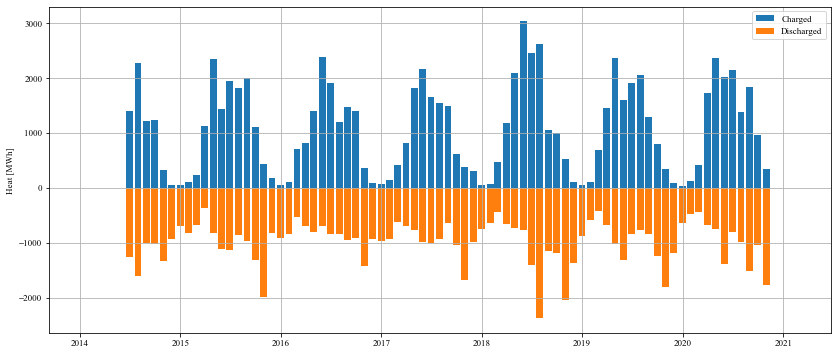

In [27]:
# Make new dataframe for the plot in order not to change the original dataframe
dfc = df.resample('1M').sum()

fig, ax = plt.subplots(figsize=(14,6))
ax.bar(dfc.index, dfc['Q_ch_bot_n'], width=pd.Timedelta(days=25), label='Charged')
ax.bar(dfc.index, -dfc['Q_dis_bot_n'], width=pd.Timedelta(days=25), label='Discharged')
ax.set_ylabel('Heat [MWh]')
ax.grid()
ax.legend()

Calculation of the flow rates using the provided flow rates and directions in the dataset for comparison to the suggested method.

In [28]:
# Make the flow directions from [0,1] to [-1,1]
df['FR_top_c'] = df['FR_top']*-2+1
df['FR_mid_c'] = df['FR_mid']*-2+1
df['FR_bot_c'] = df['FR_bot']*-2+1

Energy calculation for each diffuser using the provided flow rates and directions.

In [29]:
df['Q_top'] = df['F_top']/3600 *4190*(df['T_top']-T_ref)*10**-6 /6 * df['FR_top_c'] 
df['Q_mid'] = df['F_mid']/3600 *4190*(df['T_mid']-T_ref)*10**-6 /6 * df['FR_mid_c']
df['Q_bot'] = df['F_bot']/3600 *4190*(df['T_bot']-T_ref)*10**-6 /6 * df['FR_bot_c']

Charge and discharge energy for the provided flow rates and directions.

In [30]:
# Charge energy
df['Q_ch_dir'] = df[['Q_top','Q_mid','Q_bot']].sum(axis='columns').clip(lower=0)
# Discharge energy
df['Q_dis_dir'] = -df[['Q_top','Q_mid','Q_bot']].sum(axis='columns').clip(upper=0)

Create a pot to observe the monthly charged/discharged energy calculated using the calculated flow rates.

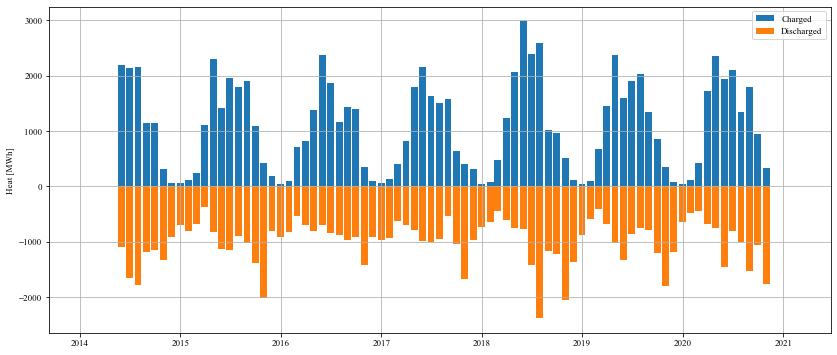

In [31]:
# Make new dataframe for the plot in order not to change the original dataframe
dfp = df.resample('1M').sum()

fig, ax = plt.subplots(figsize=(14,6))
ax.bar(dfp.index, dfp['Q_ch_dir'], width=pd.Timedelta(days=25), label='Charged')
ax.bar(dfp.index, -dfp['Q_dis_dir'], width=pd.Timedelta(days=25), label='Discharged')
ax.set_ylabel('Heat [MWh]')
ax.grid()
ax.legend()

#### Comparison of charged and discharged energy with the provided values

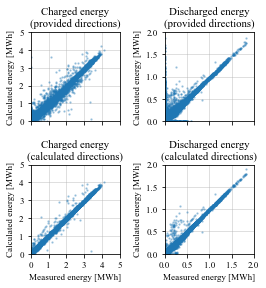

In [32]:
al = 0.3 # Transparency index for the dots

freq = '1h' # Frequency of the scatter points

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4,6.5), sharex='col', sharey=False, subplot_kw=dict(aspect='equal'))
axes = axes.flatten()

# Comparison of charge rates based on provided flow directions
axes[0].scatter(df['Q_ch_net'].resample(freq).mean(), df['Q_ch_dir'].resample(freq).mean(), s=2, alpha=al, zorder=2, rasterized=True)
axes[1].scatter(df['Q_dis_net'].resample(freq).mean(), df['Q_dis_dir'].resample(freq).mean(), s=2, alpha=al, zorder=2, rasterized=True)
axes[0].set_title('Charged energy\n(provided directions)')
axes[1].set_title('Discharged energy\n(provided directions)')

# Comparison of charge rates bassed on suggested method - calculated
axes[2].scatter(df['Q_ch_net'].resample(freq).mean(), df['Q_ch_bot_n'].resample(freq).mean(), s=2, alpha=al, zorder=2, rasterized=True)
axes[3].scatter(df['Q_dis_net'].resample(freq).mean(), df['Q_dis_bot_n'].resample(freq).mean(), s=2, alpha=al, zorder=2, rasterized=True)
axes[2].set_title('Charged energy\n(calculated directions)')
axes[3].set_title('Discharged energy\n(calculated directions)')


for i, ax in enumerate(axes):
    if i % 2 == 0:
        ax.set_xlim(0, 5)
        ax.set_ylim(0, 5)
    else:
        ax.set_xlim(0, 2)
        ax.set_ylim(0, 2)
    ax.grid(alpha=0.5)

for i in range(0,4):
    axes[i].set_ylabel('Calculated energy [MWh]')

for i in [2,3]:
    axes[i].set_xlabel('Measured energy [MWh]')

for i in [1,3]:
    axes[i].set_yticks(np.arange(0,2.5,0.5))
    axes[i].set_xticks(np.arange(0,2.5,0.5))

for i in [0,2]:
    axes[i].set_yticks(np.arange(0,6,1))
    axes[i].set_xticks(np.arange(0,6,1))

fig.subplots_adjust(wspace=0.5, hspace=-0.4)